<a href="https://colab.research.google.com/github/BuddGao/DL-Competition/blob/main/competition_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 Prediction

In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## if you haven't unzipped training data
#!unzip "drive/MyDrive/DL_Project/Train.zip" -d  "drive/MyDrive/DL_Project/"

## if you haven't unzipped val data
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"

## Custom Dataset Class

In [ ]:
## preprocess data
## create custom data class

from sklearn.model_selection import KFold
import os
import torch
import pandas as pd
from skimage import io, transform

#from monai.transforms import Compose, LoadImage, AddChannel, ScaleIntensity,RandRotate, ToTensor, RandFlip, RandZoom, Resize, RandGaussianNoise
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        
 
        p = self.label_data.iloc[idx, 1]

        subject_num = self.label_data.iloc[idx, 2]
        

        # should be only applied on image, not percentage or subject #
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}
        return sample

In [ ]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)

        # should be only applied on image, not percentage or subject #
        if self.transform:
            image = self.transform(image)
    
        sample = {'image': image, 'img_name':img_name}
        return sample

In [ ]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    ,transform = transforms.Compose([
                                                transforms.ToPILImage(),                     
                                                transforms.Resize((224, 224)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomRotation(15),
                                                
                                                transforms.ToTensor(),
                                                
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                                    
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val',
                                      transform = transforms.Compose([
                                                transforms.ToPILImage(),                     
                                                transforms.Resize((224, 224)),
                                                
                                                transforms.ToTensor(),
                                                
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                                      #,transform = transforms.Compose([
                                        #  LoadImage(),
                                         # AddChannel(),
                                          #ScaleIntensity(),
                                          #ToTensor()])
                                    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 224, 224]) 0.0 0


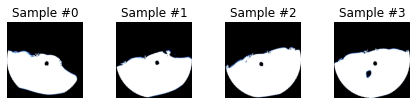

In [ ]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0304.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0301.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0302.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0303.png


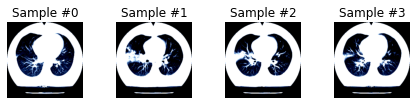

In [ ]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

##Split given train set to train & val set

### Classic

In [ ]:
## split given train set to train & val set

#dataloader = DataLoader(covid_dataset, batch_size=4, shuffle=True, num_workers=0)
print(len(covid_dataset_train_val))
train_size = int(0.7 * len(covid_dataset_train_val))
val_size = len(covid_dataset_train_val) - train_size
print(train_size, val_size)
train_dataset, val_dataset = torch.utils.data.random_split(covid_dataset_train_val, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

## test set
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

3053
2137 916


### Apply CV

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold

# generate the index of subjects for k-fold cross validation
def generate_index(dat,k):
    
    Y = list(range(0,dat[-1]['subject']+1))
    kf = KFold(n_splits=k, shuffle=True)

    n = len(Y)
    index = {'train_index':[],
             'val_index':[]}

    for train_index, val_index in kf.split(np.zeros(n), Y):
        index['train_index'].append(train_index)
        index['val_index'].append(val_index)
        
    
    return pd.DataFrame(index['train_index']).T,pd.DataFrame(index['val_index']).T

In [ ]:
# get links form subjects to images
df = pd.read_csv('drive/MyDrive/DL_Project/Train.csv')
subtoimage = []
le = []
for sub in range(0,covid_dataset_train_val[-1]['subject']+1):
  subtoimage.append(df[df['0'] == sub].index.tolist())
  le.append(len(df[df['0'] == sub].index.tolist()))

In [ ]:
# get images' index form subjects' index
def get_image_index(subindex,subtoimage):
    imageindex = []
    for sub in range(0,len(subindex)):
        imageindex.extend(subtoimage[subindex[sub]])
    return imageindex

In [ ]:
# from typing import NewType
def cv_train(pars, k=4, dir='drive/MyDrive/DL_Project/CV/',n_epochs=20):
  train_index,val_index = generate_index(covid_dataset_train_val,k)
  model_cv = []
  valid_cvloss = []
  valid_cvloss_trend = []
  for split_i in range(0,k):
    print('CV - Fold ', split_i)
    fold_dir = dir + str(split_i) + '/'

    if not os.path.isdir(fold_dir):
      os.makedirs(fold_dir)
      print("created folder : ", fold_dir)
    else:
      print(fold_dir, "folder already exists.")

    model, cri, lr = pars
    freeze_stat = True
    model_CNN = model(pretrained=True,freeze=freeze_stat).to(device)
    criterion = cri
    model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
    optimizer = optim.Adam(model_CNN_grad_paramaters, lr=lr)

    ## split given train set to train & val set by subjects
    train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
    val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
    train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
    val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

    ## training model
    model_conv, valid_loss_min, valid_loss_trend = train_model(model_CNN, criterion, optimizer,train_dataloader,val_dataloader, dir=fold_dir,n_epochs=n_epochs)

    model_cv.append(model_conv)
    valid_cvloss.append(valid_loss_min)
    valid_cvloss_trend.append(valid_loss_trend)
  
  print('----------------------Final CV loss: %.6f -----------------------' % torch.stack(valid_cvloss).cpu().data.mean() )
  
  return model_cv, valid_cvloss, valid_cvloss_trend

## Import pretrained models library

In [ ]:
## use imagenet pretrained model
## let's start with resnet34
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8c7c1d9126c65722a8634bf59e14f1951303f5e2f16d0c308e02908a73e8bba6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [ ]:
# pretrainedmodels.__dict__

NameError: ignored

## Use CUDA to speed up training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Baseline Model

In [ ]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

class CNN1(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
class CNN2(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN2, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
# reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8081579/
def conv_block(in_channels,out_channels):
    blk = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,(1,1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1))
    )
    return blk

class CNN22(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(CNN22, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.w = conv_block(3,5)
        self.convblk1 = conv_block(64,32)
        # self.part2 = self.model.features[4]
        self.convblk2 = conv_block(64,32) 
        # self.part3 = self.model.features[5]
        self.convblk3 = conv_block(128,32) 
        # self.part4 = self.model.features[6]
        self.convblk4 = conv_block(256,32)
        # self.part5 = self.model.features[7:] 
        self.convblk5 = conv_block(512,32) 
        self.lc1 = nn.Linear(32,1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        w = self.w(x)
        w = w.reshape(bs, -1)
        x = self.model.relu(self.model.bn1(self.model.conv1(x)))
        x1 = self.convblk1(x).reshape(bs,-1)
        x = self.model.layer1(x)
        x2 = self.convblk2(x).reshape(bs,-1)
        x = self.model.layer2(x)
        x3 = self.convblk3(x).reshape(bs,-1)
        x = self.model.layer3(x)
        x4 = self.convblk4(x).reshape(bs,-1)
        x = self.model.layer4(x)
        x5 = self.convblk5(x).reshape(bs,-1)
        x = w[:,0]*x1.t()+w[:,1]*x2.t()+w[:,2]*x3.t()+w[:,3]*x4.t()+w[:,4]*x5.t()
    #    x = nd.concat(w[0]*x, w[1]*x1, w[2]*x2, w[3]*x3, w[4]*x4, dim=1)
        x = x.t()
        x = x.reshape(bs,-1)
        label = self.lc1(x)
        return label

In [ ]:
# reference: https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb
class CNN3(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(2048, 512, (2,2), stride=1, padding =0)
        self.conv2 = nn.Conv2d(512, 32, (2,2), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        label = self.fc2(label)
        label = self.fc3(label)
        return label

In [ ]:
# reference: https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb
class CNN31(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN31, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(2048, 512, (2,2), stride=1, padding =0)
        self.conv2 = nn.Conv2d(512, 32, (2,2), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
# reference: https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb
class CNN32(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN32, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(2048, 512, (3,3), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(512, 8, (3,3), stride=1, padding =0)
        self.fc1 = nn.Linear(72, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        label = self.fc2(label)
        label = self.fc3(label)
        return label

In [ ]:
from torch.nn.modules import padding
# reference: https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb
class CNN33(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN33, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv11 = nn.Conv2d(2048,256,(1,1),padding='same')
        self.upsampled1 = nn.Upsample(scale_factor=2)
        self.conv12 = nn.Conv2d(256,256,(3,3),padding='same')
        self.conv21 = nn.Conv2d(1024,256,(1,1),padding='same')
        self.upsampled2 = nn.Upsample(scale_factor=2)
        self.conv22 = nn.Conv2d(256,256,(3,3))
        self.conv31 = nn.Conv2d(512,256,(1,1),padding='same')
        self.conv32 = nn.Conv2d(256,256,(3,3))
        self.conv4 = nn.Conv2d(2048,256,(3,3),stride=2) #,padding='same')
        self.relu = nn.ReLU()
        self.conv5 = nn.Conv2d(256,256,(3,3),stride=2) #,padding='same')
        
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(545792,1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(79872,1)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(12544,1)
        self.dropout4 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(2304,1)
        self.dropout5 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(256,1)
        self.fc6 = nn.Linear(5,1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.maxpool(self.model.relu(self.model.bn1(self.model.conv1(x))))
        x = self.model.layer1(x)
        c3 = self.model.layer2(x)
        c4 = self.model.layer3(c3)
        c5 = self.model.layer4(c4)

        ## Feature Pyramid Network (FPN)
        p5 = self.conv11(c5)
        p5_up = self.upsampled1(p5)
        p5 = self.conv12(p5)

        p4 = self.conv21(c4)
        p4 = torch.concat([p5_up,p4],dim=3)
        p4_up = self.upsampled2(p4)
        p4 = self.conv22(p4)

        p3 = self.conv31(c3)
        p3 = torch.concat([p4_up,p3],dim=3)
        p3 = self.conv32(p3)

        p6 = self.conv4(c5)
        p7 = self.relu(p6)
        p7 = self.conv5(p7)

        ## feature generation
        f1 = p3.reshape(bs,-1)
        dp1 = self.dropout1(f1)
        preds1 = F.relu(self.fc1(dp1))
        f2 = p4.reshape(bs,-1)
        dp2 = self.dropout2(f2)
        preds2 = F.relu(self.fc2(dp2))
        f3 = p5.reshape(bs,-1)
        dp3 = self.dropout3(f3)
        preds3 = F.relu(self.fc3(dp3))
        f4 = p6.reshape(bs,-1)
        dp4 = self.dropout4(f4)
        preds4 = F.relu(self.fc4(dp4))
        f5 = p7.reshape(bs,-1)
        dp5 = self.dropout5(f5)
        preds5 = F.relu(self.fc5(dp5))
        concat = torch.concat([preds1,preds2,preds3,preds4,preds5],dim=1)
        label = self.fc6(concat)

        return label

In [ ]:
# reference: https://www.researchsquare.com/article/rs-32957/v1
class CNN4(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(CNN4, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.conv1 = nn.Conv2d(512, 128, (2,2), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (2,2), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(20, 1)

        self.conv4 = nn.Conv1d(1,1,kernel_size=5)
        self.bn = nn.BatchNorm1d(1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        x = F.adaptive_avg_pool2d(x, x.shape[3])
        # print(x.reshape(bs,-1).size())

        l = self.fc1(x.reshape(bs, -1))
        c = self.conv4(l.reshape(bs,1,-1))
        c = self.bn(c)
        c = F.relu(c)
        l = self.fc2(l)
        
        # print(c.size()) # [8, 8, 4, 4]
        # print(l.size())

        x = torch.cat((c.reshape(bs,-1), l),1)
        label = self.fc3(x)

        return label

In [ ]:
# reference: https://towardsdatascience.com/using-pretrained-deep-convolutional-neural-networks-for-binary-classification-of-covid-19-ct-scans-3a7f7ea8b543
class CNN5(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(CNN5, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["vgg16"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["vgg16"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.fc1 = nn.Linear(25088, 512)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        # print(x.size(0))
        x = self.model._features(x)
        x = self.fc1(x.reshape(bs,-1))
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        label = self.fc4(x)
        return label

In [ ]:
# reference: https://towardsdatascience.com/using-pretrained-deep-convolutional-neural-networks-for-binary-classification-of-covid-19-ct-scans-3a7f7ea8b543
class CNN6(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN6, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["vgg19"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["vgg19"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.fc1 = nn.Linear(25088, 512)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model._features(x)
        x = self.fc1(x.reshape(bs,-1))
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        label = self.fc4(x)
        return label

In [ ]:
class CNN7(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN7, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet101"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet101"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(2048, 512, (2,2), stride=1, padding =0)
        self.conv2 = nn.Conv2d(512, 32, (2,2), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
from torchsummary import summary
model_CNN = CNN6(pretrained=True,freeze=True).to(device)
model_CNN
summary(model_CNN, input_size=(3, 224, 224))

2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 25

In [ ]:
# #Setting model and moving to device
# model_CNN = CNN1(True).to(device)

# criterion = nn.L1Loss()
# #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, dir='drive/MyDrive/DL_Project/', n_epochs=20):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    model_best = model
    valid_loss_trend = []
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        valid_loss_trend.append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            model_best = model
            model_dir = dir+'model.pth'
            torch.save(model.state_dict(), model_dir)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model_best, valid_loss_min, valid_loss_trend

In [ ]:
# model_conv=train_model(model_CNN, criterion, optimizer)

## Save result on Actual Test Data to csv File

#### Classic

In [ ]:
def save_test(model,dir):
  test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
  df = pd.DataFrame(columns=['image_name','output'])
  for batch_idx, sample_batched in enumerate(test_dataloader):
      image= sample_batched['image'].to(device)
      img_name= sample_batched['img_name']
      output = model(image).type(torch.LongTensor).reshape(-1)
      img_name = np.array(img_name).reshape(output.shape[0],1)
      o = output.cpu().data.numpy().reshape(output.shape[0],1)
      a = np.concatenate((img_name,o),axis=1)
      df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)

  #Extracting image name from the image path
  df['image_name']=df['image_name'].str.split("/").str[-1]
  df = df.sort_values('image_name',ignore_index=True)

  file_dir = dir+'predictions.zip'
  print(file_dir)
  comp_opt = dict(method='zip', archive_name='predictions.csv')
  df.to_csv(file_dir, index=False, header=False,compression=comp_opt)
  df.head()

#### CV

In [ ]:
def save_test_cv(model,dir):
  test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
  all_df = pd.DataFrame(columns=[])
  for fold_idx in range(len(model)):
    model_tmp = model[fold_idx]
    col_name = 'fold_'+str(fold_idx)
    df = pd.DataFrame(columns=['image_name',col_name])
    for batch_idx, sample_batched in enumerate(test_dataloader):
        image= sample_batched['image'].to(device)
        img_name= sample_batched['img_name']
        output = model_tmp(image).type(torch.LongTensor).reshape(-1)
        img_name = np.array(img_name).reshape(output.shape[0],1)
        o = output.cpu().data.numpy().reshape(output.shape[0],1)
        a = np.concatenate((img_name,o),axis=1)
        df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    #Extracting image name from the image path
    df['image_name']=df['image_name'].str.split("/").str[-1]
    df = df.sort_values('image_name',ignore_index=True)
    all_df[col_name] = df[col_name].astype(float)
  all_df['output'] = all_df.mean(axis=1)
  all_df['image_name'] = df['image_name']
  res = all_df[['image_name','output']]

  file_dir = dir+'predictions.zip'
  print(file_dir)
  comp_opt = dict(method='zip', archive_name='predictions.csv')
  res.to_csv(file_dir, index=False, header=False,compression=comp_opt)
  all_df.to_csv(dir+'cv_predictions.csv', index=False, header=False)
  all_df.head()

## Model Training and Comparing

In [ ]:
# #Setting model and moving to device
# model_CNN = CNN1(True).to(device)

# criterion = nn.L1Loss()
# #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
model_set = [CNN31,CNN32,CNN33] # [CNN4,CNN6,CNN7] # CNN1, CNN2, CNN4, CNN22
cri_set = [nn.SmoothL1Loss()] #[nn.L1Loss(),
optim_lr = [0.0005] # 0.0001, 0.0005, 0.001, 0.005

#### Classic

In [ ]:
from itertools import product, chain
import os

comp_model = []
comp_valid_loss = []
comp_valid_trend = []
log = pd.DataFrame(columns=['num','model','criterion','adam_lr','directory'])
root = 'drive/MyDrive/DL_Project/classic_2/'

for n, (model,cri,lr) in enumerate(product(model_set,cri_set, optim_lr)):
    model_CNN = model(True).to(device)
    criterion = cri
    optimizer = optim.Adam(model_CNN.parameters(), lr=lr)

    dir = root+str(n)+'/'
    if not os.path.isdir(dir):
      os.makedirs(dir)
      print("created folder : ", dir)
    else:
      print(dir, "folder already exists.")

    print(n,model,cri,lr,dir)

    model_best, valid_loss_min, valid_loss_trend = train_model(model_CNN, criterion, optimizer, train_dataloader, val_dataloader, dir, n_epochs=20)

    # ## load best val_model
    # model_best = model_CNN
    # model_best.load_state_dict(torch.load(dir+'model.pt'))
    # model_best.eval()

    # save test result
    save_test(model_best,dir)
    
    # value_val_loss = valid_loss_min.cpu().data()
    row = pd.Series([n,model,cri,lr,dir],index=log.columns)
    log = log.append(row,ignore_index=True)

    # comp_idx = comp_idx.append(n)
    # comp_idx_model = comp_idx_model.append(model)
    # comp_cri = comp_cri.append(cri)
    # comp_optim = comp_optim.append(optim)

    comp_model.append(model_best)
    comp_valid_loss.append(valid_loss_min)
    comp_valid_trend.append(valid_loss_trend)

drive/MyDrive/DL_Project/classic_2/0/ folder already exists.
0 <class '__main__.CNN1'> SmoothL1Loss() 0.0005 drive/MyDrive/DL_Project/classic_2/0/
Epoch 1, Batch 1 loss: 35.551823


KeyboardInterrupt: ignored

In [ ]:
log['val_loss']=torch.stack(comp_valid_loss).cpu().tolist()

log_path = root+'log.csv'
log.to_csv(root+'log.csv')
log

#### CV training

In [ ]:
from itertools import product, chain
import os

comp_model = []
comp_valid_loss = []
comp_valid_trend = []
log = pd.DataFrame(columns=['num','model','criterion','adam_lr','directory'])
root = 'drive/MyDrive/DL_Project/cv/CNN3/'

# for n, (model,cri,lr) in enumerate(product(model_set,cri_set, optim_lr))[1:]:
for n, pars in enumerate(product(model_set,cri_set, optim_lr)):
    # if n ==0:
    #   continue

    # freeze_stat = True
    # model_CNN = model(pretrained=True,freeze=freeze_stat).to(device)
    # criterion = cri
    # model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
    # optimizer = optim.Adam(model_CNN_grad_paramaters, lr=lr)

    dir = root+str(n)+'/'
    if not os.path.isdir(dir):
      os.makedirs(dir)
      print("created folder : ", dir)
    else:
      print(dir, "folder already exists.")

    print(n,pars,dir)

    model_conv, valid_loss_min, valid_loss_trend = cv_train(pars,k=4,dir = dir,n_epochs=20)

    # save test result
    save_test_cv(model_conv,dir)
    
    # value_val_loss = valid_loss_min.cpu().data()
    model,cri,lr = pars
    row = pd.Series([n,model,cri,lr,dir],index=log.columns)
    log = log.append(row,ignore_index=True)

    # comp_idx = comp_idx.append(n)
    # comp_idx_model = comp_idx_model.append(model)
    # comp_cri = comp_cri.append(cri)
    # comp_optim = comp_optim.append(optim)

    comp_model.append(model_conv)
    comp_valid_loss.append(valid_loss_min)
    comp_valid_trend.append(valid_loss_trend)

created folder :  drive/MyDrive/DL_Project/cv/CNN3/0/
0 (<class '__main__.CNN31'>, SmoothL1Loss(), 0.0005) drive/MyDrive/DL_Project/cv/CNN3/0/
CV - Fold  0
created folder :  drive/MyDrive/DL_Project/cv/CNN3/0/0/
Epoch 1, Batch 1 loss: 23.021463
Epoch 1, Batch 101 loss: 11.395896
Epoch 1, Batch 201 loss: 11.289553
Epoch: 1 	Training Loss: 10.837865 	Validation Loss: 12.559104
Validation loss decreased (inf --> 12.559104).  Saving model ...
Epoch 2, Batch 1 loss: 12.116649
Epoch 2, Batch 101 loss: 8.430355
Epoch 2, Batch 201 loss: 8.427979
Epoch: 2 	Training Loss: 8.214499 	Validation Loss: 11.652262
Validation loss decreased (12.559104 --> 11.652262).  Saving model ...
Epoch 3, Batch 1 loss: 4.794877
Epoch 3, Batch 101 loss: 7.844219
Epoch 3, Batch 201 loss: 7.252107
Epoch: 3 	Training Loss: 7.345779 	Validation Loss: 13.173133
Epoch 4, Batch 1 loss: 8.440363
Epoch 4, Batch 101 loss: 7.222564
Epoch 4, Batch 201 loss: 7.120494
Epoch: 4 	Training Loss: 7.116403 	Validation Loss: 11.212495

In [ ]:
val_loss = []
for idx in range(len(comp_valid_loss)):
  mean_val_loss = torch.stack(comp_valid_loss[idx]).cpu().data.mean()
  val_loss.append(mean_val_loss)
log['mean_val_loss'] = torch.stack(val_loss).tolist()
log_path = root+'log.csv'
log.to_csv(root+'log.csv')
log

,num,model,criterion,adam_lr,directory,mean_val_loss
0,0,<class '__main__.CNN31'>,SmoothL1Loss(),0.0005,drive/MyDrive/DL_Project/cv/CNN3/0/,7.187867
1,1,<class '__main__.CNN32'>,SmoothL1Loss(),0.0005,drive/MyDrive/DL_Project/cv/CNN3/1/,7.391855
2,2,<class '__main__.CNN33'>,SmoothL1Loss(),0.0005,drive/MyDrive/DL_Project/cv/CNN3/2/,8.621758


## Points to note:

General Rules: Participants should estimate the percentage of Covid-19 infection from each slice using Machine Learning. **Only ImageNet's pre-trained models and Lung Nodule Segmentation models are allowed**. The use of external data or other pre-trained models is not allowed. The models must be trained using the training data and evaluated using the validation data.

##Things you can try:

- The dataset is not as big and especially negative covid images are very few.
It would be better to use k-fold cross validation rather than conventional splitting.
- How would you split image splices from the same patient subject into train & val set?
- How would the information on the patient (subject #) help your prediction?
- What kind of preprocessing/data augmentation method help your model? What kind of methods would actually make your model perform worse?
- What other different CNN architectures could you explore to acheive lower MAE?
- Explore different optimizers, loss combinations, etc
- Explore different regularization methods

This is no way an exhaustive list. You might get a better idea by reading relevant research papers. Good luck!